In [2]:
import openeo, pyrosm, xarray, itertools, os, geopandas, cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from rasterio.features import rasterize

In [3]:
def bbox_to_spatial_extent(bbox) -> dict:
    west, south, east, north = bbox
    return {"west": west, "south": south, "east": east, "north": north}

In [5]:
fp = pyrosm.get_data("Berlin")
bbox = [13.307595132829988, 52.50054853432778, 13.313285933932065, 52.5036081890986]
bbox_berlin = [13.294333, 52.454927, 13.500205, 52.574409]

<Axes: >

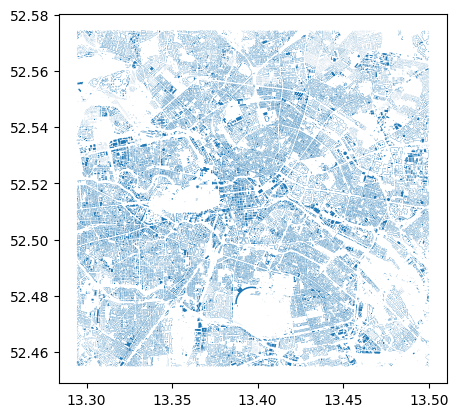

In [ ]:
osm_berlin = pyrosm.OSM(
    fp,
    bbox_berlin,
)

buildings = osm_berlin.get_buildings()
buildings.plot()

In [70]:
con = openeo.connect("https://openeo.dataspace.copernicus.eu/openeo/1.2")
con.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2' with OidcBearerAuth>

In [90]:
def copernicus_datacube(bbox, time_range, bands, max_cloud_cover=5):
    datacube = con.load_collection(
        "SENTINEL2_L2A",
        spatial_extent=bbox,
        temporal_extent=time_range,
        bands=bands,
        max_cloud_cover=max_cloud_cover,
    )#.filter('cloud_cover', lt=max_cloud_cover)
    return datacube


def save_result(datacube, format="NetCDF"):
    result = datacube.save_result(format)
    job = result.create_job()
    job.start_and_wait().download_results()

def plot_nc_rgb(filename):
    ds = xarray.load_dataset(filename)
    data = ds[["B04", "B03", "B02"]].to_array(dim="bands")

    fig, ax = plt.subplots()
    data.plot.imshow(vmin=0, vmax=2000, ax=ax)


def plot_nc_single_band(filename):
    ds = xarray.load_dataset(filename)
    data = ds[["B04"]].to_array(dim="bands")

    fig, ax = plt.subplots()

    # TODO: make this work with a better projection
    # data.plot.imshow(cmap='gray', vmin=0, vmax=2000, ax=ax)
    plt.imshow(data.squeeze(), cmap="gray", vmin=0, vmax=2000)


def plot_nc_irb(filename):
    ds = xarray.load_dataset(filename)
    data = ds[["B08", "B04", "B02"]].to_array(dim="bands")

    fig, ax = plt.subplots()
    data.plot.imshow(vmin=0, vmax=2000, ax=ax)


def draw_mask(image: np.ndarray, mask: np.ndarray) -> np.ndarray:
    """Draw bitmask onto image.

    Parameters
    ----------
    image : np.ndarray
        Image with dimensions W, H, C
    mask : np.ndarray
        Bitmask with dimensions W, H

    Returns
    -------
    np.ndarray
        Image with overlayed bitmask (W, H, C)
    """
    mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    masked_image = image.copy()
    masked_image = np.where(
        mask.astype(int), np.array([0, 0, 255]), masked_image
    ).astype(np.float32)
    return cv2.addWeighted(image, 0.3, masked_image, 0.7, 0)


def nc_to_rgb(filename):
    ds = xarray.load_dataset(filename)
    data = ds[["B04", "B03", "B02"]].to_array(dim="bands").to_numpy().transpose(1, 2, 0)
    normalized = np.clip(data / 2000, 0, 1)
    return normalized


def nc_to_rgbir(filename):
    ds = xarray.load_dataset(filename)
    return ds[["B04", "B03", "B02", "B08"]].to_array(dim="bands").to_numpy()


def nc_to_single_band(filename):
    ds = xarray.load_dataset(filename)
    return ds[["B04"]].to_array(dim="bands").to_numpy().squeeze()

def nc_to_scl_band(filename):
    ds = xarray.load_dataset(filename)
    return ds[["SCL"]].to_array(dim="bands").to_numpy().squeeze()

def nc_to_ir_band(filename):
    ds = xarray.load_dataset(filename)
    return ds[["B08"]].to_array(dim="bands").to_numpy().squeeze()

def rasterize_buildings(
    buildings: geopandas.geodataframe.GeoDataFrame,
    raster_width=1427,
    raster_height=1361,
) -> np.ndarray:
    xmin, ymin, xmax, ymax = buildings.total_bounds
    xres = (xmax - xmin) / raster_width
    yres = (ymax - ymin) / raster_height
    return rasterize(
        shapes=buildings.geometry,
        out_shape=(raster_height, raster_width),
        transform=(xres, 0, xmin, 0, -yres, ymax),
    )

def save_defined(
    bbox,
    out_folder,
    total_time_range=["2022-05-01", "2024-05-01"],
    time_ranges_to_save=None,
    bands=["B04", "B03", "B02", "B08", "SCL"],
    max_cloud_cover=5,
):
    if not time_ranges_to_save:
        time_ranges_to_save = pd.date_range(
            total_time_range[0], total_time_range[1], 6
        ).date

    for time_start, time_end in itertools.pairwise(time_ranges_to_save):
        datacube = copernicus_datacube(
            bbox, [time_start, time_end], bands, max_cloud_cover=max_cloud_cover
        )
        if not os.path.exists(out_folder):
            os.mkdir(out_folder)
        #datacube.mean_time().download(f"{out_folder}/{time_start}:{time_end}.nc")
        save_result(datacube)
        plot_nc_rgb(f"{out_folder}/{time_start}:{time_end}.nc")

#### RGB plots

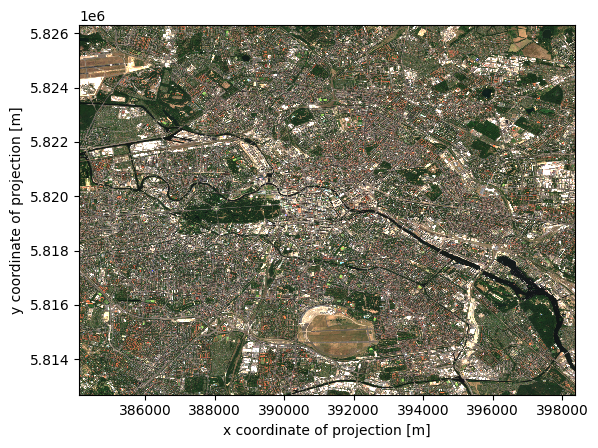

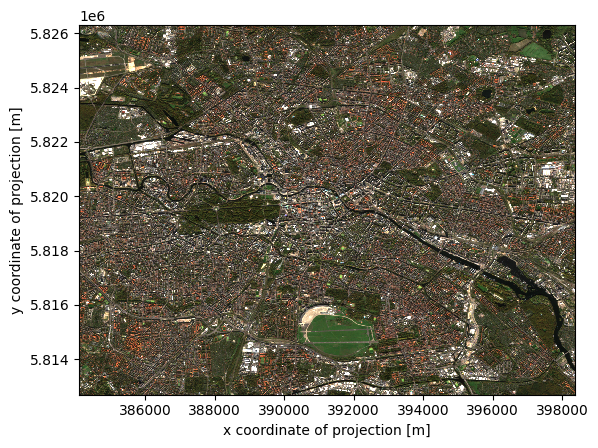

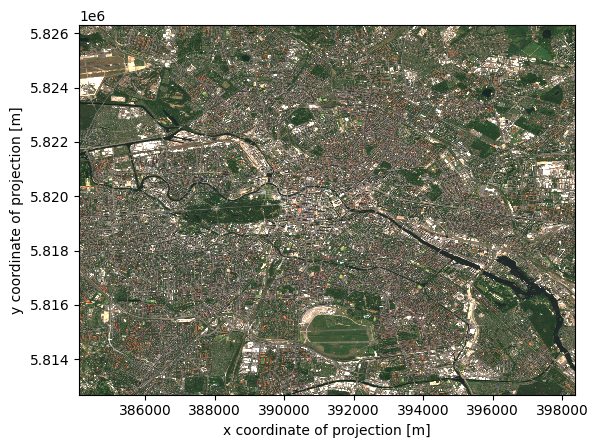

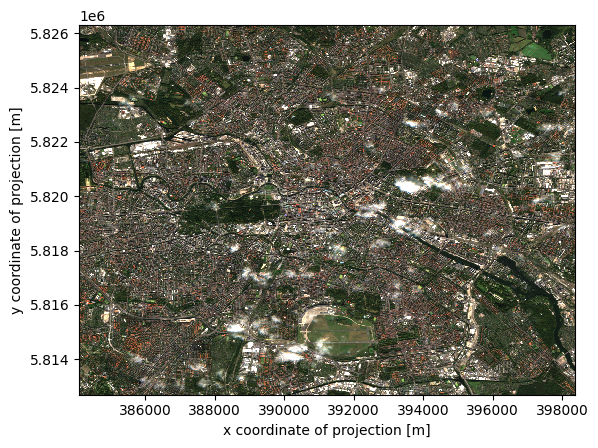

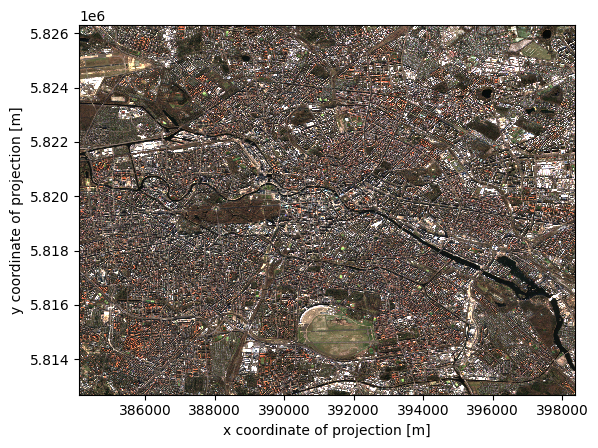

In [ ]:
save_defined(bbox_to_spatial_extent(bbox_berlin), "berlin")

#### IR plot

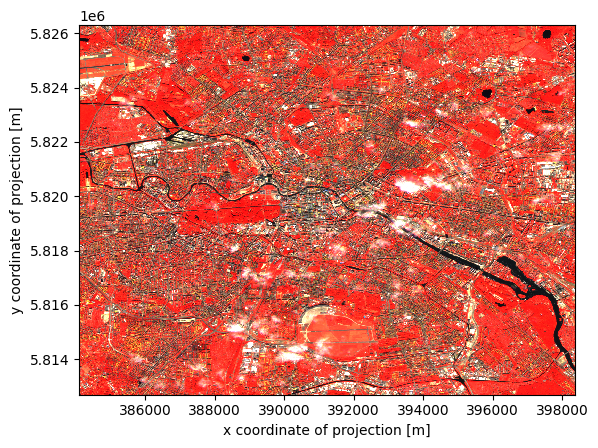

In [87]:
plot_nc_irb("berlin/2023-07-13:2023-12-06.nc")

#### Single band plot

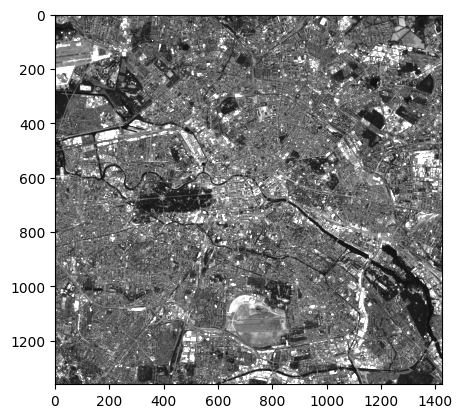

In [ ]:
plot_nc_single_band("berlin/2022-05-01:2022-09-24.nc")

#### Building mask plots

<Figure size 640x480 with 0 Axes>

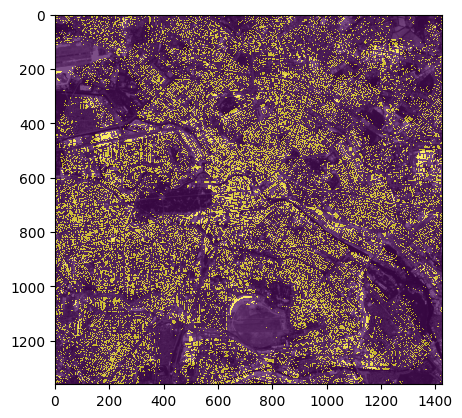

In [49]:
rasterized_buildings = rasterize_buildings(buildings)
plt.figure()
plot_nc_single_band("berlin/2022-05-01:2022-09-24.nc")
plt.imshow(rasterized_buildings, interpolation="none", alpha=0.7)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


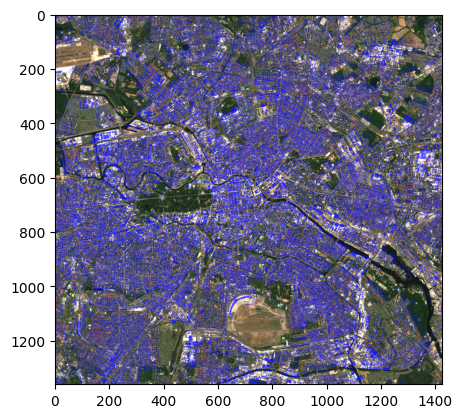

In [48]:
mask_rgb = draw_mask(nc_to_rgb("berlin/2022-05-01:2022-09-24.nc"), rasterized_buildings)
plt.imshow(mask_rgb)

#### Determine cloudiness

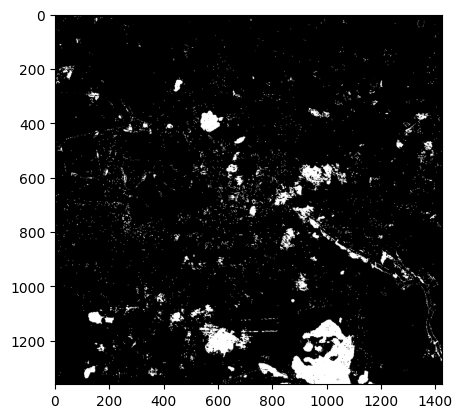

In [272]:
def clouds(filename, scl_thresh = 5, ir_thresh = 300):
    scl = scl_thresh < nc_to_scl_band(filename)
    ir = ir_thresh > nc_to_ir_band(filename)
    clouds = np.logical_and(scl, ~ir)
    return clouds

cloudy_day = clouds("berlin/2023-07-13:2023-12-06.nc")
plt.imshow(cloudy_day, cmap="gray")

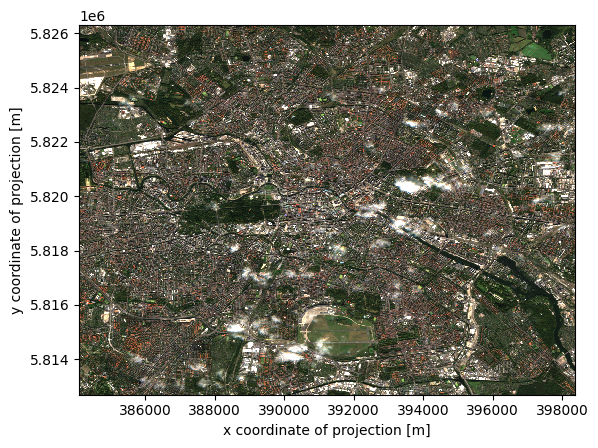

In [273]:
plot_nc_rgb("berlin/2023-07-13:2023-12-06.nc")

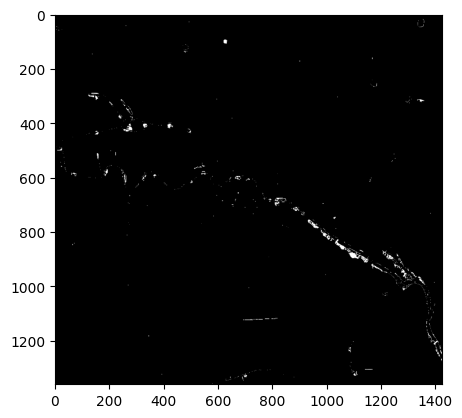

In [274]:
clear_day = clouds("berlin/2022-05-01:2022-09-24.nc")
plt.imshow(clear_day,cmap="gray")

In [276]:
def cloudiness(clouds):
    return np.linalg.norm(clouds) / len(clouds)
print(cloudiness(cloudy_day), cloudiness(clear_day))

0.2433377876695715 0.07134304831117329
